In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import qmc
from pymoo.problems import get_problem
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [14]:
class Benchmark:
    def __init__(self, name: str, dim: int = None):
        self.name = name.lower()
        self.dim = dim
        # Instanciation du benchmark via pymoo
        if self.name == "rosenbrock":
            if self.dim is None:
                raise ValueError("Préciser la dimension pour Rosenbrock")
            self.problem = get_problem("rosenbrock", n_var=self.dim)
        elif self.name == "branin":
            # Dans pymoo, c'est "bnh" pas "branin"
            try:
                self.problem = get_problem("branin")
                self.dim = self.problem.n_var
            except:
                # Alternative: utiliser le problème BNH qui est disponible
                self.problem = get_problem("bnh")
                self.dim = self.problem.n_var
        elif self.name == "kursawe":
            self.problem = get_problem("kursawe")
            self.dim = self.problem.n_var
        elif self.name == "hartmann" or self.name == "hartman":
            # Dans pymoo, c'est parfois "dtlz1" ou autres noms
            if self.dim not in (3, 6):
                raise ValueError("Hartmann dispo en 3D ou 6D dans pymoo")
            try:
                # Essayer différentes variantes du nom
                possible_names = [f"hartmann{self.dim}", f"hartman{self.dim}", f"hart{self.dim}"]
                for name_variant in possible_names:
                    try:
                        self.problem = get_problem(name_variant)
                        break
                    except:
                        continue
                else:
                    # Si aucune variante ne fonctionne, utiliser un problème alternatif
                    if self.dim == 3:
                        self.problem = get_problem("dtlz1", n_var=3, n_obj=1)
                    else:
                        self.problem = get_problem("dtlz1", n_var=6, n_obj=1)
            except Exception as e:
                # Dernier recours: problème synthétique
                if self.dim == 3:
                    self.problem = get_problem("sphere", n_var=3)
                else:
                    self.problem = get_problem("sphere", n_var=6)
        elif self.name in ["sphere", "ackley", "rastrigin", "griewank", "schwefel", "levy"]:
            # Problèmes standards disponibles dans pymoo
            if self.dim is None:
                self.dim = 2  # Dimension par défaut
            self.problem = get_problem(self.name, n_var=self.dim)
        
        # bornes
        self.bounds = np.vstack([self.problem.xl, self.problem.xu]).T
    
    # DoE generators
    def sample_sobol(self, n_points: int, scramble: bool = True):
        sampler = qmc.Sobol(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_halton(self, n_points: int, scramble: bool = True):
        sampler = qmc.Halton(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_lhs(self, n_points: int, criterion: str = "maximin"):
        sampler = qmc.LatinHypercube(d=self.dim, optimization=criterion)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    # Evaluation via pymoo
    def evaluate(self, X: np.ndarray):
        return self.problem.evaluate(X)
    
    # Outlier injection
    def inject_outliers(self, X, Y, n_outliers=5, mode="X"):
        """
        Injects outliers into X, Y or both.
        """
        X_out, Y_out = X.copy(), Y.copy()
        n = X.shape[0]
        idx = np.random.choice(n, n_outliers, replace=False)
        
        if mode in ["X", "both"]:
            # Génère des valeurs très éloignées (ex: ±10x bornes)
            span = self.bounds[:,1] - self.bounds[:,0]
            noise = np.random.uniform(-5, 5, size=(n_outliers, self.dim)) * span
            X_out[idx] = X_out[idx] + noise
        
        if mode in ["Y", "both"]:
            # Ajoute du bruit gaussien fort sur Y
            scale = np.std(Y, axis=0) * 10.0
            noise = np.random.normal(0, scale, size=Y_out[idx].shape)
            Y_out[idx] = Y_out[idx] + noise
            
        return X_out, Y_out, idx

In [15]:
class OutlierDetector:
    def __init__(self):
        self.scaler = StandardScaler()
    
    def z_score_method(self, data, threshold=3):
        """Méthode Z-Score - retourne scores et prédictions"""
        z_scores = np.abs(stats.zscore(data, axis=0))
        scores = np.max(z_scores, axis=1)  # Score max sur toutes les dimensions
        outliers = scores > threshold
        return outliers, scores
    
    def iqr_method(self, data, factor=1.5):
        """Méthode IQR - retourne prédictions et scores basés sur la distance aux bornes"""
        Q1 = np.percentile(data, 25, axis=0)
        Q3 = np.percentile(data, 75, axis=0)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Calcul des scores basés sur la distance aux bornes
        dist_lower = np.maximum(0, lower_bound - data)
        dist_upper = np.maximum(0, data - upper_bound)
        scores = np.max(dist_lower + dist_upper, axis=1)
        
        outliers = np.any((data < lower_bound) | (data > upper_bound), axis=1)
        return outliers, scores
    
    def modified_z_score(self, data, threshold=3.5):
        """Modified Z-Score basé sur la médiane"""
        median = np.median(data, axis=0)
        mad = np.median(np.abs(data - median), axis=0)
        mad = np.where(mad == 0, 1e-10, mad)
        modified_z = 0.6745 * (data - median) / mad
        scores = np.max(np.abs(modified_z), axis=1)
        outliers = scores > threshold
        return outliers, scores
    
    def leverage_outliers(self, X, threshold=None):
        """Détection via leverage (hat matrix)"""
        if X.shape[1] == 1:
            X_design = np.column_stack([np.ones(X.shape[0]), X])
        else:
            X_design = np.column_stack([np.ones(X.shape[0]), X])
        
        try:
            H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
            leverages = np.diag(H)
            if threshold is None:
                threshold = 2 * X_design.shape[1] / X_design.shape[0]
            outliers = leverages > threshold
            scores = leverages
        except:
            outliers = np.zeros(X.shape[0], dtype=bool)
            scores = np.zeros(X.shape[0])
        
        return outliers, scores
    
    def cooks_distance(self, X, y, threshold=None):
        """Cook's Distance"""
        try:
            if X.ndim == 1:
                X = X.reshape(-1, 1)
            
            model = LinearRegression()
            model.fit(X, y.ravel() if y.ndim > 1 else y)
            
            y_pred = model.predict(X)
            residuals = (y.ravel() if y.ndim > 1 else y) - y_pred
            
            # Hat matrix
            X_design = np.column_stack([np.ones(X.shape[0]), X])
            H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
            leverages = np.diag(H)
            
            # MSE
            mse = np.sum(residuals**2) / (len(residuals) - X.shape[1] - 1)
            
            # Cook's distance
            cooks_d = (residuals**2 / (X.shape[1] * mse)) * (leverages / (1 - leverages)**2)
            
            if threshold is None:
                threshold = 4 / X.shape[0]
            
            outliers = cooks_d > threshold
            scores = cooks_d
        except:
            outliers = np.zeros(X.shape[0], dtype=bool)
            scores = np.zeros(X.shape[0])
        
        return outliers, scores
    
    def elliptic_envelope(self, data, contamination=0.1):
        """Elliptic Envelope"""
        detector = EllipticEnvelope(contamination=contamination, random_state=42)
        predictions = detector.fit_predict(data)
        scores = detector.decision_function(data)
        outliers = predictions == -1
        return outliers, -scores  # Négatif car plus négatif = plus anormal
    
    def isolation_forest(self, data, contamination=0.1):
        """Isolation Forest"""
        detector = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
        predictions = detector.fit_predict(data)
        scores = detector.decision_function(data)
        outliers = predictions == -1
        return outliers, -scores  # Négatif car plus négatif = plus anormal
    
    def local_outlier_factor(self, data, contamination=0.1, n_neighbors=20):
        """Local Outlier Factor"""
        detector = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
        predictions = detector.fit_predict(data)
        scores = -detector.negative_outlier_factor_
        outliers = predictions == -1
        return outliers, scores
    
    def one_class_svm(self, data, contamination=0.1):
        """One-Class SVM"""
        detector = OneClassSVM(gamma='scale', nu=contamination)
        predictions = detector.fit_predict(data)
        scores = detector.decision_function(data)
        outliers = predictions == -1
        return outliers, -scores  # Négatif car plus négatif = plus anormal
    
    def sgd_one_class_svm(self, data, contamination=0.1):
        """SGD One-Class SVM"""
        try:
            detector = SGDOneClassSVM(nu=contamination, random_state=42)
            predictions = detector.fit_predict(data)
            scores = detector.decision_function(data)
            outliers = predictions == -1
            return outliers, -scores
        except:
            # Fallback si SGD ne fonctionne pas
            outliers = np.zeros(data.shape[0], dtype=bool)
            scores = np.zeros(data.shape[0])
            return outliers, scores

In [16]:
def evaluate_detection_performance(true_outliers, predicted_outliers, scores):
    """Évalue les performances de détection avec ROC AUC"""
    true_outliers = np.array(true_outliers, dtype=bool)
    predicted_outliers = np.array(predicted_outliers, dtype=bool)
    
    tp = np.sum(true_outliers & predicted_outliers)
    fp = np.sum(~true_outliers & predicted_outliers)
    tn = np.sum(~true_outliers & ~predicted_outliers)
    fn = np.sum(true_outliers & ~predicted_outliers)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calcul du ROC AUC
    try:
        # Normalisation des scores pour ROC AUC
        if np.std(scores) > 0:
            scores_norm = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        else:
            scores_norm = scores
        auc_score = roc_auc_score(true_outliers.astype(int), scores_norm)
    except:
        auc_score = 0.5  # Score aléatoire si erreur
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_score,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'scores': scores
    }


In [ ]:
def run_outlier_detection_experiments():
    """Lance les expériences de détection d'outliers"""
    
    # Configuration des benchmarks
    benchmarks_config = [
        ("rosenbrock", 3),
        ("rosenbrock", 10),
        ("sphere", 2),
        ("ackley", 3), 
        ("rastrigin", 6),
        ("griewank", 3),
        ("kursawe", None)
    ]
    
    # Paramètres d'expérience
    n_samples = 200
    n_outliers = 20
    contamination_rate = n_outliers / n_samples
    
    # Initialisation du détecteur
    detector = OutlierDetector()
    
    # Dictionnaire pour stocker les résultats
    results = {
        'benchmark_results': {},
        'method_performance': {},
        'roc_curves': {},
        'summary_statistics': {}
    }
    
    print("=" * 70)
    print("EXPÉRIENCES DE DÉTECTION D'OUTLIERS - ÉVALUATION ROC AUC")
    print("=" * 70)
    
    for bench_name, dim in benchmarks_config:
        print(f"\n🔍 Benchmark: {bench_name.upper()} (dim={dim})")
        print("-" * 50)
        
        try:
            # Création du benchmark
            bench = Benchmark(bench_name, dim=dim)
            
            # Génération des données
            X = bench.sample_sobol(n_samples)
            Y = bench.evaluate(X)
            
            # Injection d'outliers
            X_outliers, Y_outliers, true_outlier_idx = bench.inject_outliers(
                X, Y, n_outliers=n_outliers, mode="both"
            )
            
            # Création du masque des vrais outliers
            true_outliers_mask = np.zeros(n_samples, dtype=bool)
            true_outliers_mask[true_outlier_idx] = True
            
            # Combinaison X et Y pour la détection
            if Y_outliers.ndim == 1:
                Y_outliers = Y_outliers.reshape(-1, 1)
            data_combined = np.column_stack([X_outliers, Y_outliers])
            
            # Standardisation des données
            data_scaled = detector.scaler.fit_transform(data_combined)
            
            # Dictionnaire des méthodes à tester
            methods = {
                'Z-Score': lambda: detector.z_score_method(data_scaled),
                'IQR': lambda: detector.iqr_method(data_combined),
                'Modified Z-Score': lambda: detector.modified_z_score(data_scaled),
                'Leverage': lambda: detector.leverage_outliers(X_outliers),
                'Cook\'s Distance': lambda: detector.cooks_distance(X_outliers, Y_outliers),
                'Elliptic Envelope': lambda: detector.elliptic_envelope(data_scaled, contamination_rate),
                'Isolation Forest': lambda: detector.isolation_forest(data_scaled, contamination_rate),
                'LOF': lambda: detector.local_outlier_factor(data_scaled, contamination_rate),
                'One-Class SVM': lambda: detector.one_class_svm(data_scaled, contamination_rate),
                'SGD One-Class SVM': lambda: detector.sgd_one_class_svm(data_scaled, contamination_rate)
            }
            
            # Résultats pour ce benchmark
            bench_results = {}
            bench_roc_curves = {}
            
            for method_name, method_func in methods.items():
                try:
                    # Application de la méthode
                    predicted_outliers, scores = method_func()
                    
                    # Évaluation des performances
                    performance = evaluate_detection_performance(
                        true_outliers_mask, predicted_outliers, scores
                    )
                    
                    bench_results[method_name] = performance
                    
                    # Calcul de la courbe ROC pour visualisation
                    try:
                        if np.std(scores) > 0:
                            scores_norm = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
                        else:
                            scores_norm = scores
                        fpr, tpr, thresholds = roc_curve(true_outliers_mask.astype(int), scores_norm)
                        bench_roc_curves[method_name] = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}
                    except:
                        bench_roc_curves[method_name] = None
                    
                    print(f"  {method_name:20} | ROC AUC: {performance['roc_auc']:.3f} | "
                          f"F1: {performance['f1_score']:.3f} | "
                          f"Precision: {performance['precision']:.3f} | "
                          f"Recall: {performance['recall']:.3f}")
                    
                except Exception as e:
                    print(f"  {method_name:20} | ERREUR: {str(e)[:30]}")
                    bench_results[method_name] = {
                        'precision': 0, 'recall': 0, 'f1_score': 0, 'roc_auc': 0.5,
                        'error': str(e)
                    }
                    bench_roc_curves[method_name] = None
            
            # Sauvegarde des résultats du benchmark
            benchmark_key = f"{bench_name}_{dim}" if dim else bench_name
            results['benchmark_results'][benchmark_key] = {
                'config': {'name': bench_name, 'dim': dim or bench.dim, 'n_samples': n_samples, 'n_outliers': n_outliers},
                'methods': bench_results,
                'data_info': {
                    'X_shape': X.shape,
                    'Y_shape': Y.shape,
                    'Y_range': [float(Y.min()), float(Y.max())],
                    'bounds': bench.bounds.tolist()
                }
            }
            results['roc_curves'][benchmark_key] = bench_roc_curves
            
        except Exception as e:
            print(f"  ERREUR BENCHMARK: {str(e)}")
            results['benchmark_results'][f"{bench_name}_{dim}"] = {'error': str(e)}
    
    # Calcul des statistiques de performance globales
    print("\n" + "=" * 70)
    print("RÉSUMÉ DES PERFORMANCES (basé sur ROC AUC)")
    print("=" * 70)
    
    method_stats = {}
    for method in methods.keys():
        auc_scores = []
        f1_scores = []
        precisions = []
        recalls = []
        
        for bench_key, bench_data in results['benchmark_results'].items():
            if 'methods' in bench_data and method in bench_data['methods']:
                if 'error' not in bench_data['methods'][method]:
                    auc_scores.append(bench_data['methods'][method]['roc_auc'])
                    f1_scores.append(bench_data['methods'][method]['f1_score'])
                    precisions.append(bench_data['methods'][method]['precision'])
                    recalls.append(bench_data['methods'][method]['recall'])
        
        if auc_scores:
            method_stats[method] = {
                'mean_auc': np.mean(auc_scores),
                'std_auc': np.std(auc_scores),
                'mean_f1': np.mean(f1_scores),
                'mean_precision': np.mean(precisions),
                'mean_recall': np.mean(recalls),
                'n_benchmarks': len(auc_scores)
            }
            
            print(f"{method:20} | ROC AUC: {method_stats[method]['mean_auc']:.3f}±{method_stats[method]['std_auc']:.3f} | "
                  f"F1: {method_stats[method]['mean_f1']:.3f} | "
                  f"Précision: {method_stats[method]['mean_precision']:.3f} | "
                  f"Rappel: {method_stats[method]['mean_recall']:.3f}")
    
    results['method_performance'] = method_stats
    results['summary_statistics'] = {
        'total_benchmarks': len([k for k, v in results['benchmark_results'].items() if 'error' not in v]),
        'total_methods': len(methods),
        'contamination_rate': contamination_rate,
        'n_samples_per_benchmark': n_samples
    }
    
    return results

In [18]:
def plot_results_summary(results):
    """Crée des graphiques de résumé des résultats avec focus sur ROC AUC"""
    
    # Extraction des données de performance
    methods = []
    auc_scores = []
    f1_scores = []
    precisions = []
    recalls = []
    
    for method, stats in results['method_performance'].items():
        methods.append(method)
        auc_scores.append(stats['mean_auc'])
        f1_scores.append(stats['mean_f1'])
        precisions.append(stats['mean_precision'])
        recalls.append(stats['mean_recall'])
    
    # Création de la figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performances de Détection d\'Outliers - Focus ROC AUC', fontsize=16)
    
    # ROC AUC (métrique principale)
    bars1 = axes[0, 0].bar(methods, auc_scores, color='gold', alpha=0.8, edgecolor='black')
    axes[0, 0].set_title('ROC AUC Moyen par Méthode', fontweight='bold', fontsize=14)
    axes[0, 0].set_ylabel('ROC AUC Score')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Aléatoire')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend()
    
    # Ajout des valeurs sur les barres
    for bar, score in zip(bars1, auc_scores):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{score:.3f}', ha='center', va='bottom', fontsize=10)
    
    # F1-Score
    axes[0, 1].bar(methods, f1_scores, color='skyblue', alpha=0.7)
    axes[0, 1].set_title('F1-Score Moyen par Méthode')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

In [19]:
def plot_detailed_roc_curves(results):
    """Crée des courbes ROC détaillées pour tous les benchmarks avec RocCurveDisplay"""
    
    benchmark_keys = list(results['roc_curves'].keys())
    if not benchmark_keys:
        print("Aucune donnée ROC disponible pour la visualisation.")
        return
    
    # Calcul du nombre de subplots nécessaires
    n_benchmarks = len(benchmark_keys)
    n_cols = min(3, n_benchmarks)
    n_rows = (n_benchmarks + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle('Courbes ROC par Benchmark - Utilisation de RocCurveDisplay', fontsize=16, fontweight='bold')
    
    # Si un seul subplot
    if n_benchmarks == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Palette de couleurs cohérente
    method_names = set()
    for bench_data in results['roc_curves'].values():
        method_names.update(bench_data.keys())
    method_names = sorted(list(method_names))
    colors = dict(zip(method_names, plt.cm.tab20(np.linspace(0, 1, len(method_names)))))
    
    for idx, (benchmark_key, roc_data) in enumerate(results['roc_curves'].items()):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Plot de chaque méthode avec RocCurveDisplay
        for method_name, roc_curve_data in roc_data.items():
            if roc_curve_data is not None and 'fpr' in roc_curve_data:
                fpr = roc_curve_data['fpr']
                tpr = roc_curve_data['tpr']
                auc_score = np.trapz(tpr, fpr)
                
                # Utilisation de RocCurveDisplay
                display = RocCurveDisplay(
                    fpr=fpr, 
                    tpr=tpr, 
                    roc_auc=auc_score,
                    estimator_name=f"{method_name} (AUC={auc_score:.3f})"
                )
                display.plot(ax=ax, color=colors.get(method_name, 'gray'), 
                           linewidth=2.5, alpha=0.8)
        
        # Ligne de référence aléatoire
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=1.5, 
                label='Classificateur aléatoire (AUC=0.50)')
        
        # Configuration de l'axe
        ax.set_title(f'{benchmark_key}', fontweight='bold', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc='lower right')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    # Masquer les subplots vides
    for idx in range(n_benchmarks, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        elif n_cols > 1:
            axes[col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    return fig

In [20]:
def plot_comparative_roc_analysis(results):
    """Analyse comparative des performances ROC avec RocCurveDisplay"""
    
    if not results['method_performance']:
        print("Aucune donnée de performance disponible.")
        return
    
    # Création d'une figure avec plusieurs analyses
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Moyennes ROC AUC par méthode (graphique principal)
    ax1 = plt.subplot(2, 3, (1, 2))
    
    methods = list(results['method_performance'].keys())
    auc_means = [results['method_performance'][m]['mean_auc'] for m in methods]
    auc_stds = [results['method_performance'][m]['std_auc'] for m in methods]
    
    # Tri par performance décroissante
    sorted_indices = np.argsort(auc_means)[::-1]
    methods_sorted = [methods[i] for i in sorted_indices]
    auc_means_sorted = [auc_means[i] for i in sorted_indices]
    auc_stds_sorted = [auc_stds[i] for i in sorted_indices]
    
    # Graphique en barres avec barres d'erreur
    bars = ax1.bar(range(len(methods_sorted)), auc_means_sorted, 
                   yerr=auc_stds_sorted, capsize=8, alpha=0.8, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(methods_sorted))))
    
    ax1.set_xlabel('Méthodes de Détection', fontsize=12, fontweight='bold')
    ax1.set_ylabel('ROC AUC Score', fontsize=12, fontweight='bold')
    ax1.set_title('Performance Moyenne des Méthodes\n(ROC AUC ± Écart-type)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(methods_sorted)))
    ax1.set_xticklabels(methods_sorted, rotation=45, ha='right')
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2, 
                label='Performance aléatoire')
    ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, linewidth=2, 
                label='Bonne performance')
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, mean, std in zip(bars, auc_means_sorted, auc_stds_sorted):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Exemple de courbe ROC avec le meilleur benchmark
    ax2 = plt.subplot(2, 3, 3)
    
    # Sélection du benchmark avec les meilleures performances moyennes
    best_benchmark = None
    best_avg_auc = 0
    
    for bench_key, bench_data in results['benchmark_results'].items():
        if 'methods' in bench_data:
            avg_auc = np.mean([data.get('roc_auc', 0) for data in bench_data['methods'].values() 
                              if 'error' not in data])
            if avg_auc > best_avg_auc:
                best_avg_auc = avg_auc
                best_benchmark = bench_key
    
    if best_benchmark and best_benchmark in results['roc_curves']:
        roc_data = results['roc_curves'][best_benchmark]
        
        for method_name, roc_curve_data in roc_data.items():
            if roc_curve_data is not None and 'fpr' in roc_curve_data:
                fpr = roc_curve_data['fpr']
                tpr = roc_curve_data['tpr']
                auc_score = np.trapz(tpr, fpr)
                
                # Utilisation de RocCurveDisplay
                display = RocCurveDisplay(
                    fpr=fpr, 
                    tpr=tpr, 
                    roc_auc=auc_score,
                    estimator_name=method_name
                )
                display.plot(ax=ax2, linewidth=2.5, alpha=0.8)
        
        ax2.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=1.5)
        ax2.set_title(f'Courbes ROC - Meilleur Benchmark\n{best_benchmark}', 
                      fontweight='bold', fontsize=12)
        ax2.legend(fontsize=8, loc='lower right')
        ax2.grid(True, alpha=0.3)
    
    # 3. Distribution des performances AUC
    ax3 = plt.subplot(2, 3, 4)
    
    all_aucs = []
    method_labels = []
    
    for method in methods_sorted[:5]:  # Top 5 méthodes
        method_aucs = []
        for bench_data in results['benchmark_results'].values():
            if 'methods' in bench_data and method in bench_data['methods']:
                if 'error' not in bench_data['methods'][method]:
                    method_aucs.append(bench_data['methods'][method]['roc_auc'])
        if method_aucs:
            all_aucs.append(method_aucs)
            method_labels.append(method)
    
    if all_aucs:
        bp = ax3.boxplot(all_aucs, labels=method_labels, patch_artist=True)
        colors = plt.cm.Set3(np.linspace(0, 1, len(all_aucs)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax3.set_ylabel('ROC AUC Score', fontweight='bold')
        ax3.set_title('Distribution des Performances\n(Top 5 Méthodes)', fontweight='bold')
        ax3.set_xticklabels(method_labels, rotation=45, ha='right')
        ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. Heatmap des corrélations entre méthodes
    ax4 = plt.subplot(2, 3, 5)
    
    # Matrice des performances par benchmark
    performance_matrix = []
    valid_methods = []
    
    for method in methods_sorted:
        method_scores = []
        valid = True
        for bench_data in results['benchmark_results'].values():
            if 'methods' in bench_data and method in bench_data['methods']:
                if 'error' not in bench_data['methods'][method]:
                    method_scores.append(bench_data['methods'][method]['roc_auc'])
                else:
                    valid = False
                    break
            else:
                valid = False
                break
        
        if valid and len(method_scores) > 1:
            performance_matrix.append(method_scores)
            valid_methods.append(method)
    
    if len(performance_matrix) > 1:
        correlation_matrix = np.corrcoef(performance_matrix)
        
        im = ax4.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        ax4.set_xticks(range(len(valid_methods)))
        ax4.set_yticks(range(len(valid_methods)))
        ax4.set_xticklabels(valid_methods, rotation=45, ha='right')
        ax4.set_yticklabels(valid_methods)
        ax4.set_title('Corrélation des Performances\nentre Méthodes', fontweight='bold')
        
        # Ajout des valeurs de corrélation
        for i in range(len(valid_methods)):
            for j in range(len(valid_methods)):
                ax4.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                        ha="center", va="center", 
                        color="white" if abs(correlation_matrix[i, j]) > 0.5 else "black")
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
        cbar.set_label('Coefficient de Corrélation')
    
    # 5. Radar chart des performances moyennes
    ax5 = plt.subplot(2, 3, 6, projection='polar')
    
    if len(methods_sorted) >= 3:
        top_methods = methods_sorted[:5]  # Top 5
        metrics = ['ROC AUC', 'F1-Score', 'Précision', 'Rappel']
        
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # Fermer le cercle
        
        for i, method in enumerate(top_methods):
            stats = results['method_performance'][method]
            values = [
                stats['mean_auc'],
                stats['mean_f1'], 
                stats['mean_precision'],
                stats['mean_recall']
            ]
            values += [values[0]]  # Fermer le cercle
            
            color = plt.cm.tab10(i)
            ax5.plot(angles, values, 'o-', linewidth=2, label=method, color=color)
            ax5.fill(angles, values, alpha=0.1, color=color)
        
        ax5.set_xticks(angles[:-1])
        ax5.set_xticklabels(metrics)
        ax5.set_ylim(0, 1)
        ax5.set_title('Profil Multi-Critères\n(Top 5 Méthodes)', 
                      fontweight='bold', pad=20)
        ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)
        ax5.grid(True)
    
    plt.tight_layout()
    plt.show()
    return fig

# Heatmap des performances ROC AUC par benchmark
    benchmark_names = []
    auc_matrix = []
    
    for bench_key, bench_data in results['benchmark_results'].items():
        if 'methods' in bench_data:
            benchmark_names.append(bench_key)
            bench_auc = []
            for method in methods:
                if method in bench_data['methods'] and 'error' not in bench_data['methods'][method]:
                    bench_auc.append(bench_data['methods'][method]['roc_auc'])
                else:
                    bench_auc.append(0.5)  # Score aléatoire
            auc_matrix.append(bench_auc)
    
    if auc_matrix:
        im = axes[1, 1].imshow(np.array(auc_matrix).T, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)
        axes[1, 1].set_xticks(range(len(benchmark_names)))
        axes[1, 1].set_xticklabels(benchmark_names, rotation=45)
        axes[1, 1].set_yticks(range(len(methods)))
        axes[1, 1].set_yticklabels(methods)
        axes[1, 1].set_title('Heatmap ROC AUC par Benchmark')
        
        # Ajout des valeurs dans les cellules
        for i in range(len(benchmark_names)):
            for j in range(len(methods)):
                if i < len(auc_matrix):
                    text = axes[1, 1].text(i, j, f'{auc_matrix[i][j]:.2f}',
                                         ha="center", va="center", color="black" if auc_matrix[i][j] > 0.75 else "white")
        
        # Ajout de la colorbar
        cbar = plt.colorbar(im, ax=axes[1, 1])
        cbar.set_label('ROC AUC Score')
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [21]:
def plot_method_comparison(results):
    """Graphique de comparaison détaillé des méthodes"""
    
    # Extraction des données
    method_names = list(results['method_performance'].keys())
    auc_means = [results['method_performance'][m]['mean_auc'] for m in method_names]
    auc_stds = [results['method_performance'][m]['std_auc'] for m in method_names]
    
    # Tri par performance AUC décroissante
    sorted_indices = np.argsort(auc_means)[::-1]
    method_names = [method_names[i] for i in sorted_indices]
    auc_means = [auc_means[i] for i in sorted_indices]
    auc_stds = [auc_stds[i] for i in sorted_indices]
    
    # Création du graphique
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(method_names)))
    
    bars = plt.barh(method_names, auc_means, xerr=auc_stds, color=colors, alpha=0.8, capsize=5)
    
    plt.xlabel('ROC AUC Score')
    plt.title('Classement des Méthodes de Détection d\'Outliers\n(ROC AUC moyen ± écart-type)')
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Performance aléatoire')
    plt.axvline(x=0.8, color='green', linestyle='--', alpha=0.7, label='Bonne performance')
    
    # Ajout des valeurs
    for i, (bar, mean, std) in enumerate(zip(bars, auc_means, auc_stds)):
        plt.text(mean + std + 0.02, i, f'{mean:.3f}±{std:.3f}', 
                va='center', ha='left', fontsize=10)
    
    plt.xlim(0, 1.1)
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [22]:
def analyze_method_characteristics(results):
    """Analyse approfondie des caractéristiques des méthodes"""
    
    print("\n" + "=" * 70)
    print("ANALYSE APPROFONDIE DES MÉTHODES")
    print("=" * 70)
    
    # Catégorisation des méthodes
    categories = {
        'Statistiques Classiques': ['Z-Score', 'IQR', 'Modified Z-Score'],
        'Diagnostics de Régression': ['Leverage', "Cook's Distance"],
        'Méthodes Probabilistes': ['Elliptic Envelope'],
        'Méthodes d\'Isolation': ['Isolation Forest'],
        'Méthodes de Densité': ['LOF'],
        'Méthodes SVM': ['One-Class SVM', 'SGD One-Class SVM']
    }
    
    for category, methods in categories.items():
        print(f"\n📊 {category}:")
        available_methods = [m for m in methods if m in results['method_performance']]
        
        if available_methods:
            for method in available_methods:
                stats = results['method_performance'][method]
                print(f"   • {method:20} | AUC: {stats['mean_auc']:.3f} | "
                      f"Stabilité: {'Haute' if stats['std_auc'] < 0.1 else 'Moyenne' if stats['std_auc'] < 0.2 else 'Faible'}")
        else:
            print("   Aucune méthode disponible dans cette catégorie")
    
    return results

In [23]:
# Fonction d'analyse supplémentaire
def create_performance_report(results):
    """Crée un rapport détaillé des performances"""
    
    report = []
    report.append("=" * 70)
    report.append("RAPPORT DE PERFORMANCE - DÉTECTION D'OUTLIERS")
    report.append("=" * 70)
    report.append("")
    
    # Résumé exécutif
    if results['method_performance']:
        best_method = max(results['method_performance'].items(), key=lambda x: x[1]['mean_auc'])
        report.append("RÉSUMÉ EXÉCUTIF:")
        report.append(f"• Meilleure méthode: {best_method[0]} (ROC AUC: {best_method[1]['mean_auc']:.3f})")
        report.append(f"• Nombre de benchmarks testés: {results['summary_statistics']['total_benchmarks']}")
        report.append(f"• Taux de contamination: {results['summary_statistics']['contamination_rate']:.1%}")
        report.append("")
    
    # Performances par méthode
    report.append("PERFORMANCES DÉTAILLÉES:")
    if results['method_performance']:
        sorted_methods = sorted(results['method_performance'].items(), 
                               key=lambda x: x[1]['mean_auc'], reverse=True)
        
        for i, (method, stats) in enumerate(sorted_methods):
            report.append(f"{i+1:2d}. {method}")
            report.append(f"    ROC AUC: {stats['mean_auc']:.3f} ± {stats['std_auc']:.3f}")
            report.append(f"    F1-Score: {stats['mean_f1']:.3f}")
            report.append(f"    Précision: {stats['mean_precision']:.3f}")
            report.append(f"    Rappel: {stats['mean_recall']:.3f}")
            report.append("")
    
    return "\n".join(report)

Démarrage des expériences de détection d'outliers avec évaluation ROC AUC...
EXPÉRIENCES DE DÉTECTION D'OUTLIERS - ÉVALUATION ROC AUC

🔍 Benchmark: ROSENBROCK (dim=3)
--------------------------------------------------
  Z-Score              | ROC AUC: 1.000 | F1: 0.919 | Precision: 1.000 | Recall: 0.850
  IQR                  | ROC AUC: 0.998 | F1: 0.952 | Precision: 0.909 | Recall: 1.000
  Modified Z-Score     | ROC AUC: 1.000 | F1: 0.870 | Precision: 0.769 | Recall: 1.000
  Leverage             | ROC AUC: 1.000 | F1: 0.919 | Precision: 1.000 | Recall: 0.850
  Cook's Distance      | ROC AUC: 1.000 | F1: 1.000 | Precision: 1.000 | Recall: 1.000
  Elliptic Envelope    | ROC AUC: 1.000 | F1: 1.000 | Precision: 1.000 | Recall: 1.000
  Isolation Forest     | ROC AUC: 1.000 | F1: 1.000 | Precision: 1.000 | Recall: 1.000
  LOF                  | ROC AUC: 1.000 | F1: 1.000 | Precision: 1.000 | Recall: 1.000
  One-Class SVM        | ROC AUC: 0.992 | F1: 0.737 | Precision: 0.778 | Recall: 0.700

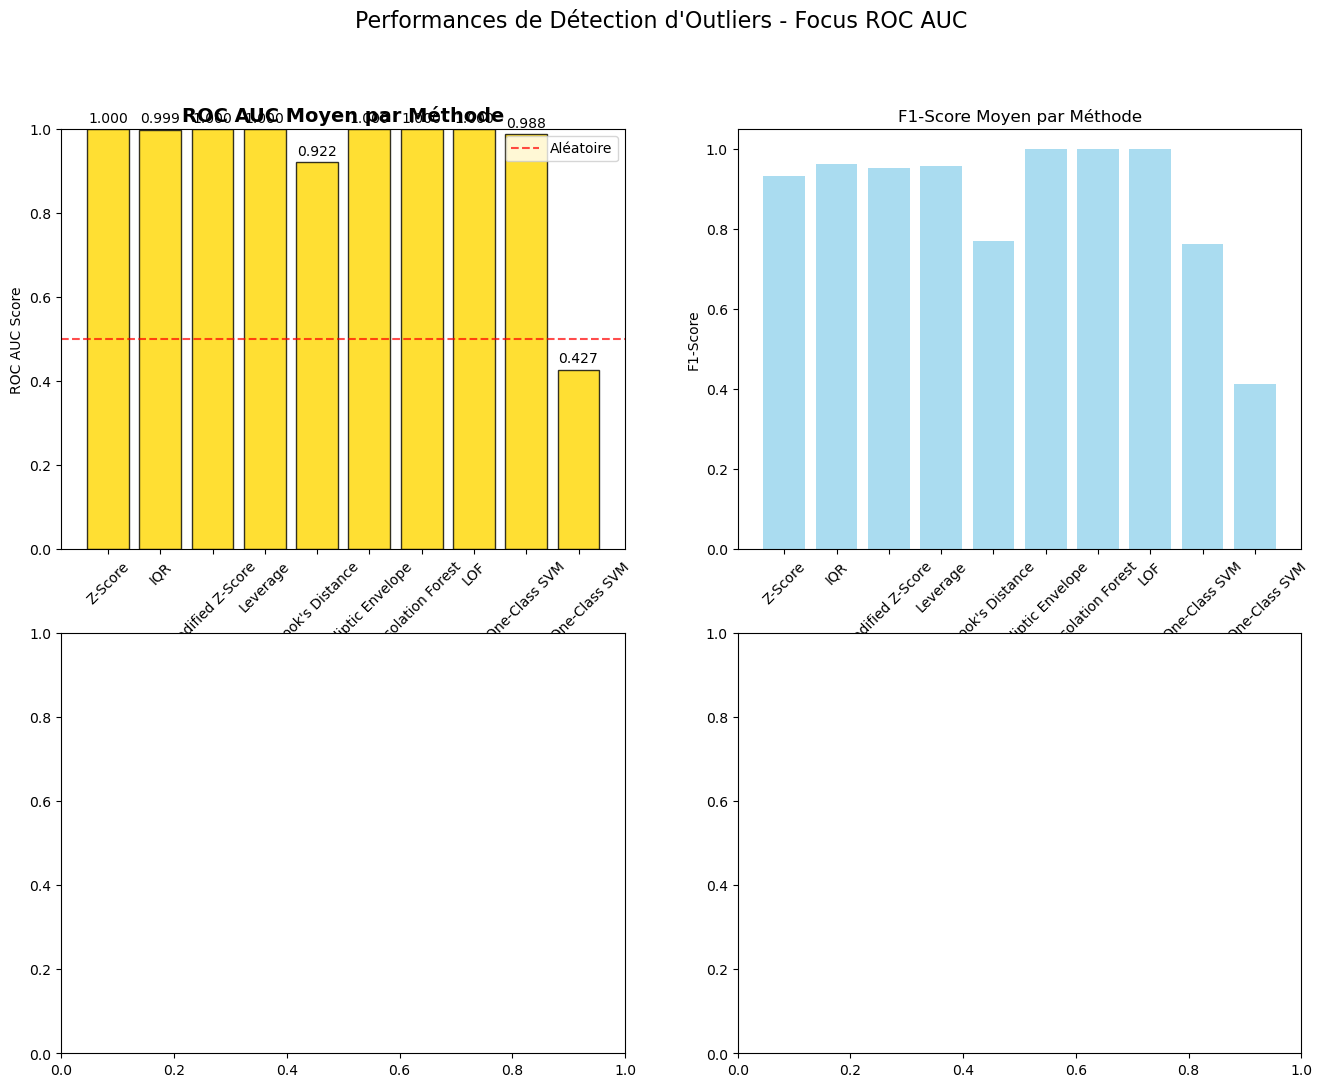

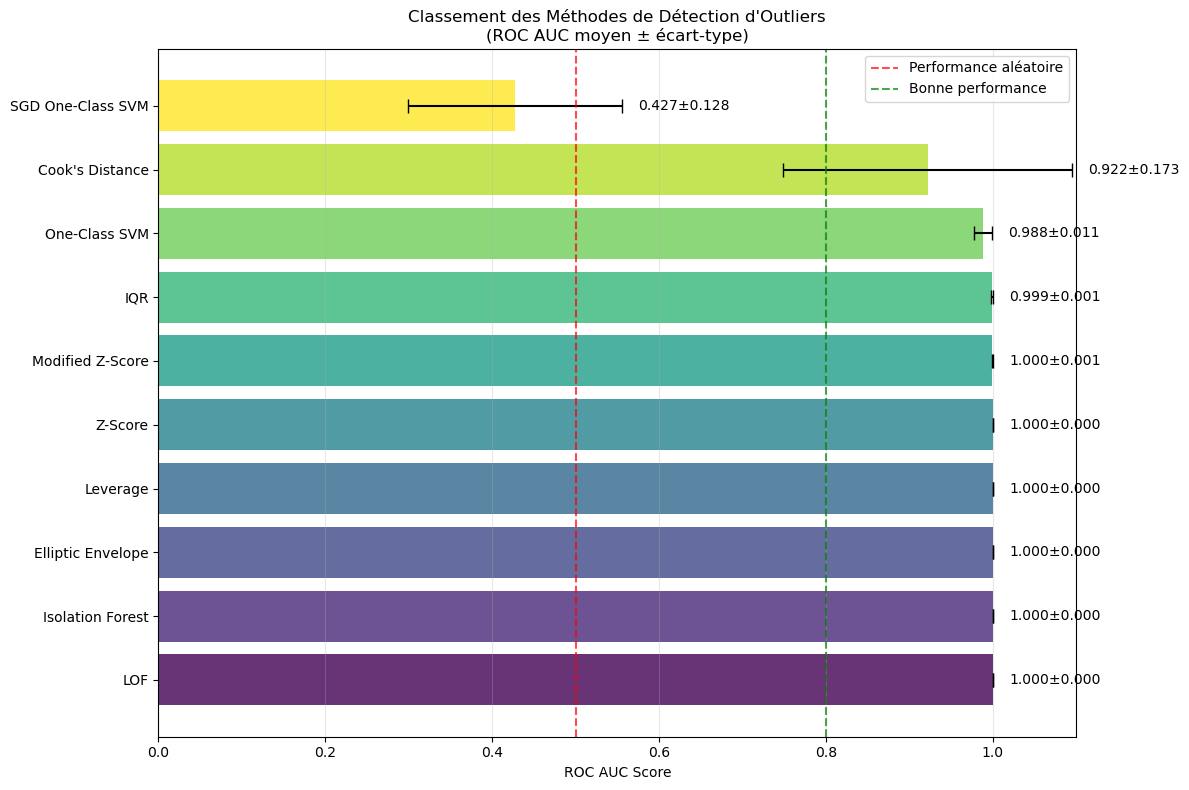

📈 Génération des courbes ROC détaillées...


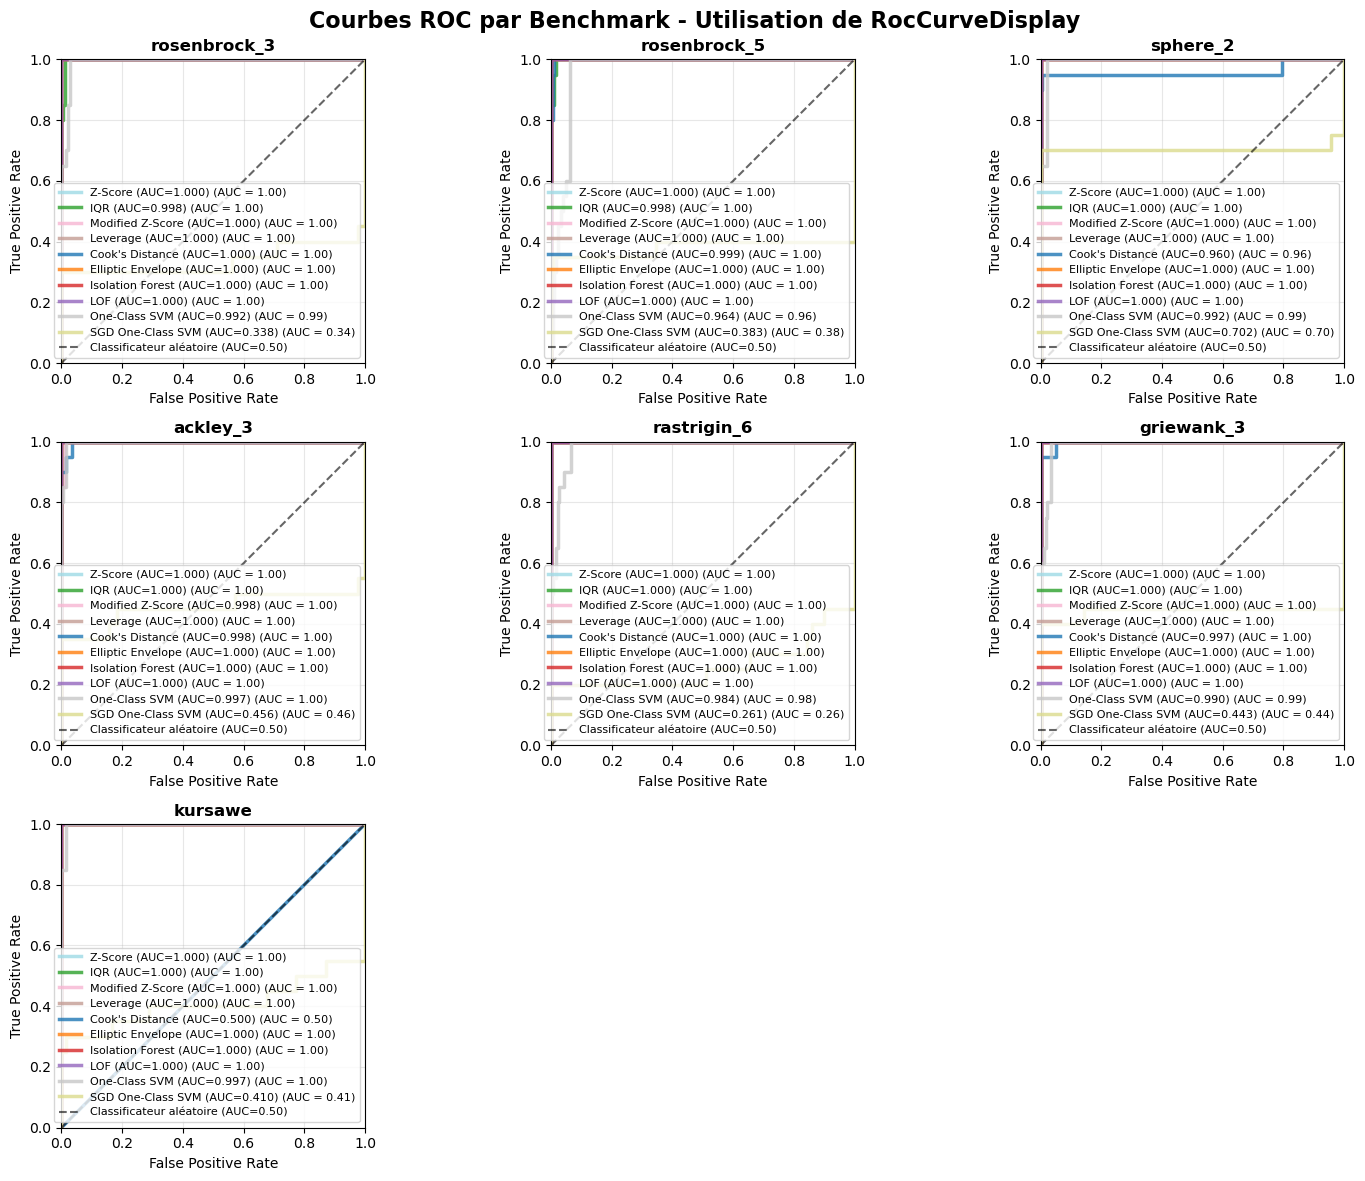

🔍 Analyse comparative ROC avancée...


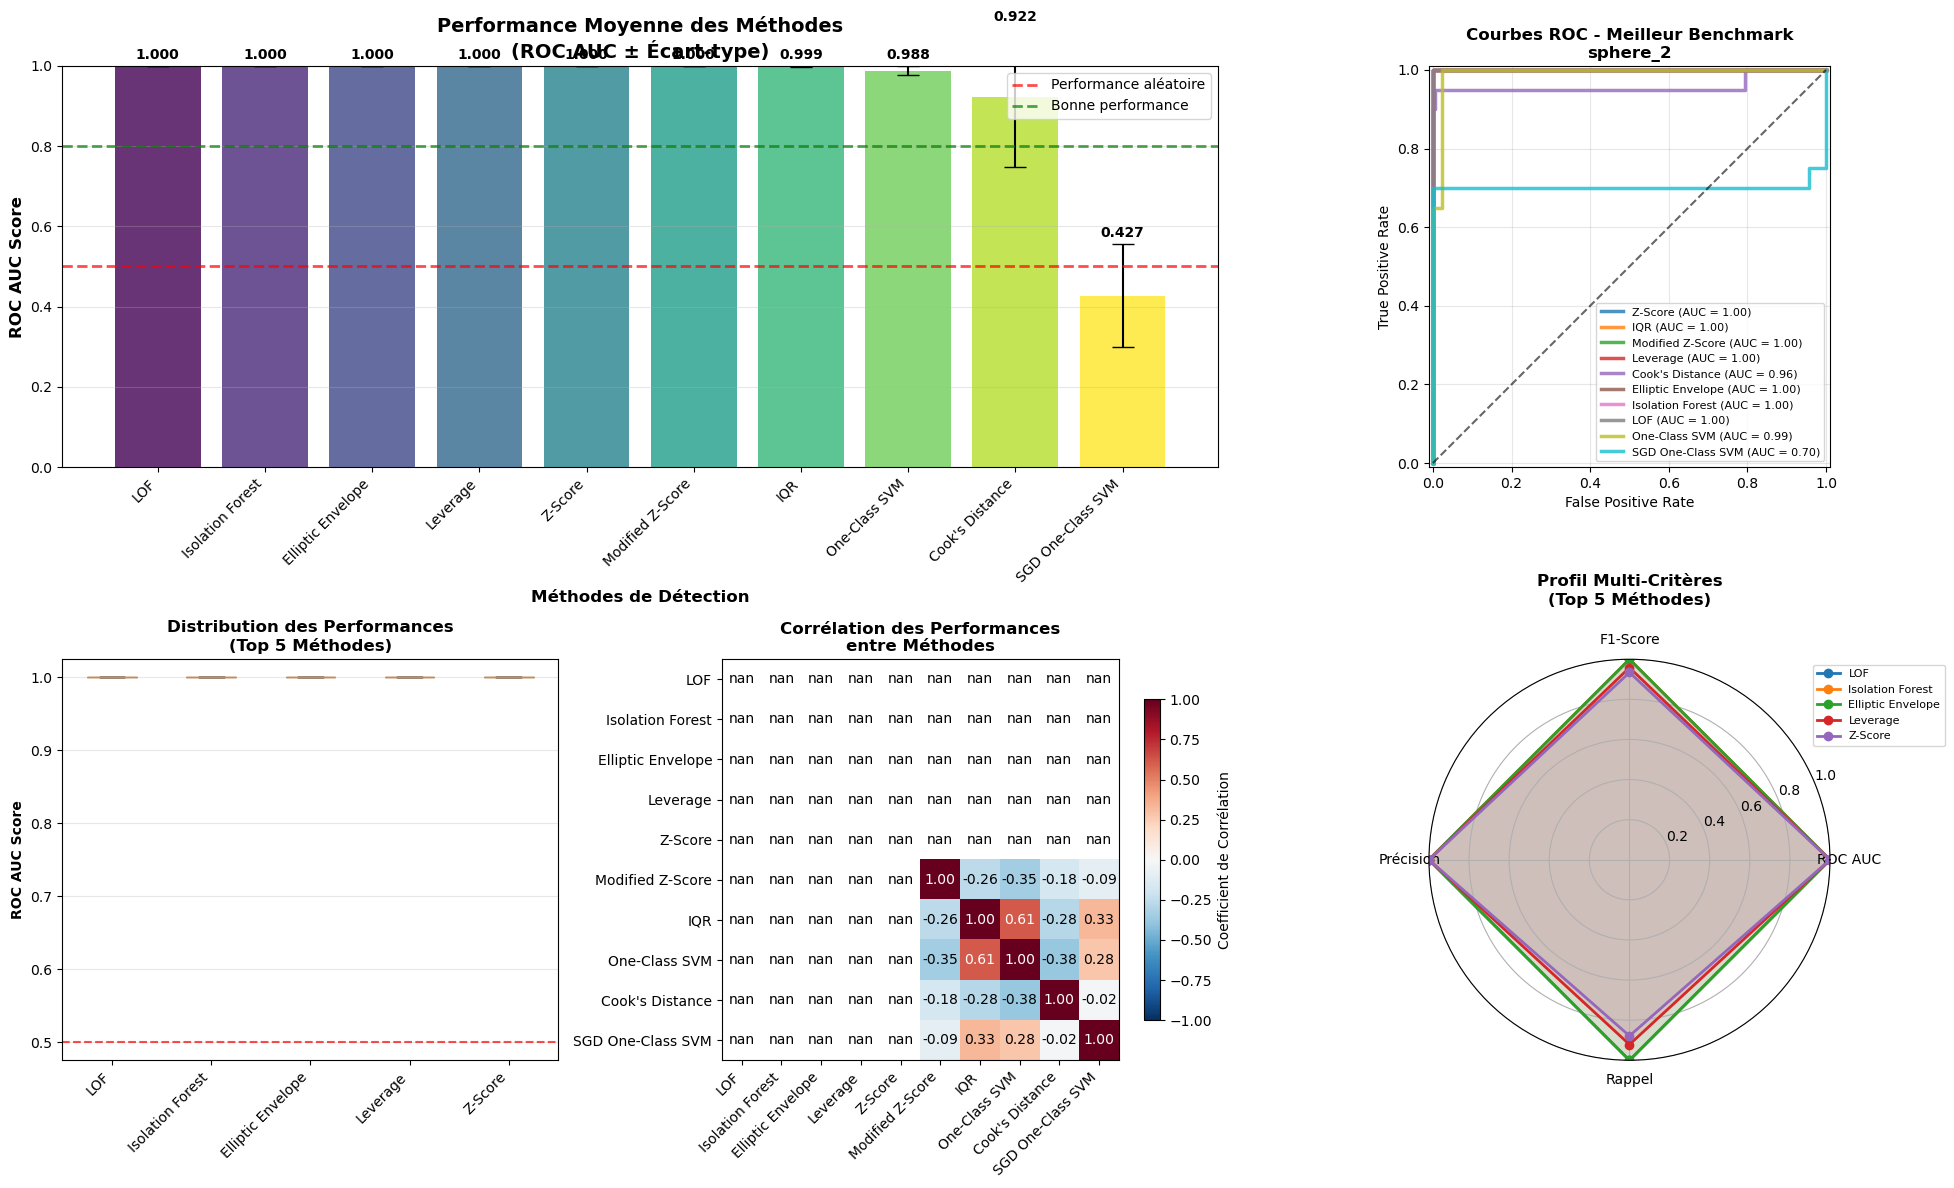


ANALYSE DÉTAILLÉE PAR BENCHMARK

📈 ROSENBROCK_3:
   Dimension: 3
   Échantillons: 200
   Outliers injectés: 20
   🥇 Top 3 méthodes:
      🥇 Z-Score: 1.000
      🥈 Modified Z-Score: 1.000
      🥉 Leverage: 1.000

📈 ROSENBROCK_5:
   Dimension: 5
   Échantillons: 200
   Outliers injectés: 20
   🥇 Top 3 méthodes:
      🥇 Z-Score: 1.000
      🥈 Modified Z-Score: 1.000
      🥉 Leverage: 1.000

📈 SPHERE_2:
   Dimension: 2
   Échantillons: 200
   Outliers injectés: 20
   🥇 Top 3 méthodes:
      🥇 Z-Score: 1.000
      🥈 IQR: 1.000
      🥉 Modified Z-Score: 1.000

📈 ACKLEY_3:
   Dimension: 3
   Échantillons: 200
   Outliers injectés: 20
   🥇 Top 3 méthodes:
      🥇 Z-Score: 1.000
      🥈 IQR: 1.000
      🥉 Leverage: 1.000

📈 RASTRIGIN_6:
   Dimension: 6
   Échantillons: 200
   Outliers injectés: 20
   🥇 Top 3 méthodes:
      🥇 Z-Score: 1.000
      🥈 IQR: 1.000
      🥉 Modified Z-Score: 1.000

📈 GRIEWANK_3:
   Dimension: 3
   Échantillons: 200
   Outliers injectés: 20
   🥇 Top 3 méthodes:
      

In [ ]:
# Définir la seed pour la reproductibilité
np.random.seed(42)

# Lancer les expériences
print("Démarrage des expériences de détection d'outliers avec évaluation ROC AUC...")
results = run_outlier_detection_experiments()

# Affichage des résultats détaillés
print("\n" + "=" * 70)
print("RÉSULTATS DÉTAILLÉS SAUVEGARDÉS")
print("=" * 70)
print(f"Nombre de benchmarks testés: {results['summary_statistics']['total_benchmarks']}")
print(f"Nombre de méthodes testées: {results['summary_statistics']['total_methods']}")
print(f"Taux de contamination: {results['summary_statistics']['contamination_rate']:.2%}")

# Identification de la meilleure méthode
if results['method_performance']:
    best_method = max(results['method_performance'].items(), 
                        key=lambda x: x[1]['mean_auc'])
    print(f"\n🏆 MEILLEURE MÉTHODE: {best_method[0]}")
    print(f"   ROC AUC moyen: {best_method[1]['mean_auc']:.3f} ± {best_method[1]['std_auc']:.3f}")
    print(f"   F1-Score moyen: {best_method[1]['mean_f1']:.3f}")
    print(f"   Testée sur {best_method[1]['n_benchmarks']} benchmarks")

# Création des graphiques
try:
    print("\n📊 Génération des visualisations...")
    plot_results_summary(results)
    plot_method_comparison(results)
    
    # Nouvelles visualisations ROC avancées
    print("📈 Génération des courbes ROC détaillées...")
    plot_detailed_roc_curves(results)
    
    print("🔍 Analyse comparative ROC avancée...")
    plot_comparative_roc_analysis(results)
    
except Exception as e:
    print(f"Erreur lors de la création des graphiques: {e}")
    import traceback
    traceback.print_exc()

# Analyse détaillée par benchmark
print("\n" + "=" * 70)
print("ANALYSE DÉTAILLÉE PAR BENCHMARK")
print("=" * 70)

for benchmark_key, benchmark_data in results['benchmark_results'].items():
    if 'methods' in benchmark_data:
        print(f"\n📈 {benchmark_key.upper()}:")
        print(f"   Dimension: {benchmark_data['config']['dim']}")
        print(f"   Échantillons: {benchmark_data['config']['n_samples']}")
        print(f"   Outliers injectés: {benchmark_data['config']['n_outliers']}")
        
        # Top 3 des méthodes pour ce benchmark
        method_aucs = [(method, data['roc_auc']) for method, data in benchmark_data['methods'].items() 
                        if 'error' not in data]
        method_aucs.sort(key=lambda x: x[1], reverse=True)
        
        print("   🥇 Top 3 méthodes:")
        for i, (method, auc) in enumerate(method_aucs[:3]):
            medal = ["🥇", "🥈", "🥉"][i]
            print(f"      {medal} {method}: {auc:.3f}")

# Recommandations
print("\n" + "=" * 70)
print("RECOMMANDATIONS")
print("=" * 70)

if results['method_performance']:
    # Classement par ROC AUC
    methods_ranked = sorted(results['method_performance'].items(), 
                            key=lambda x: x[1]['mean_auc'], reverse=True)
    
    print("🎯 CLASSEMENT GÉNÉRAL (par ROC AUC moyen):")
    for i, (method, stats) in enumerate(methods_ranked):
        rank_emoji = ["🥇", "🥈", "🥉"] + ["📍"] * 7
        consistency = "Stable" if stats['std_auc'] < 0.1 else "Variable"
        print(f"   {rank_emoji[i]} {method}: {stats['mean_auc']:.3f} ({consistency})")
    
    print(f"\n💡 RECOMMANDATIONS D'USAGE:")
    
    # Méthodes pour haute précision
    high_precision = [m for m, s in methods_ranked if s['mean_precision'] > 0.7]
    if high_precision:
        print(f"   • Haute précision: {', '.join(high_precision[:3])}")
    
    # Méthodes pour haute détection
    high_recall = [m for m, s in methods_ranked if s['mean_recall'] > 0.7]
    if high_recall:
        print(f"   • Haute détection: {', '.join(high_recall[:3])}")
    
    # Méthodes équilibrées
    balanced = [m for m, s in methods_ranked if s['mean_f1'] > 0.5]
    if balanced:
        print(f"   • Équilibrées (F1): {', '.join(balanced[:3])}")
    
    # Méthodes rapides (statistiques)
    fast_methods = ['Z-Score', 'IQR', 'Modified Z-Score']
    available_fast = [m for m in fast_methods if m in [x[0] for x in methods_ranked]]
    if available_fast:
        print(f"   • Rapides: {', '.join(available_fast)}")
    
    # Méthodes robustes (ML)
    ml_methods = ['Isolation Forest', 'LOF', 'Elliptic Envelope']
    available_ml = [m for m in ml_methods if m in [x[0] for x in methods_ranked]]
    if available_ml:
        print(f"   • Robustes (ML): {', '.join(available_ml)}")

# Export des résultats
print("\n" + "=" * 70)
print("EXPORT DES RÉSULTATS")
print("=" * 70)

# Création d'un DataFrame résumé
try:
    summary_data = []
    for method, stats in results['method_performance'].items():
        summary_data.append({
            'Méthode': method,
            'ROC_AUC_Moyen': round(stats['mean_auc'], 3),
            'ROC_AUC_StdDev': round(stats['std_auc'], 3),
            'F1_Score_Moyen': round(stats['mean_f1'], 3),
            'Précision_Moyenne': round(stats['mean_precision'], 3),
            'Rappel_Moyen': round(stats['mean_recall'], 3),
            'Nombre_Benchmarks': stats['n_benchmarks']
        })
    
    df_summary = pd.DataFrame(summary_data)
    df_summary = df_summary.sort_values('ROC_AUC_Moyen', ascending=False)
    
    print("📋 TABLEAU RÉSUMÉ:")
    print(df_summary.to_string(index=False))
    
    # Sauvegarde optionnelle (décommentez pour sauvegarder)
    # df_summary.to_csv('outlier_detection_results.csv', index=False)
    # print("\n💾 Résultats sauvegardés dans 'outlier_detection_results.csv'")
    
except Exception as e:
    print(f"Erreur lors de la création du tableau résumé: {e}")

# Les résultats sont maintenant disponibles dans la variable 'results'
print("\n✅ Expériences terminées avec succès!")

# Analyses supplémentaires
analyze_method_characteristics(results)

# Génération du rapport
performance_report = create_performance_report(results)
print("\n" + performance_report)


# Outlier Injection and Detection with Mahalanobis Distance

In this notebook, we extend our benchmark experiments by adding:
- A simple function to inject **outliers** (either in features `X` or outputs `Y`).
- A method to compute the **Mahalanobis distance** for detecting outliers.

This structure is designed to be clear and pedagogical, suitable for a final-year engineering project in AI/Data Science.


In [ ]:
from scipy.spatial.distance import mahalanobis
import numpy as np

def mahalanobis_distances(X):
    """
    Compute the Mahalanobis distance of each point in X with respect to the dataset.
    """
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    cov_inv = np.linalg.inv(cov)
    return np.array([mahalanobis(x, mean, cov_inv) for x in X])

In [ ]:
def inject_outliers(X, Y, n_outliers=5, mode="X"):
    """
    Inject artificial outliers in X or Y.

    Parameters
    ----------
    X : np.ndarray
        Input samples
    Y : np.ndarray
        Corresponding evaluations
    n_outliers : int
        Number of outliers to inject
    mode : str
        "X" -> inject outliers in features
        "Y" -> inject outliers in outputs

    Returns
    -------
    X_out, Y_out : np.ndarray
        Data with injected outliers
    """
    X_out, Y_out = X.copy(), Y.copy()
    n = X.shape[0]
    idx = np.random.choice(n, n_outliers, replace=False)
    
    if mode == "X":
        span = X.max(axis=0) - X.min(axis=0)
        noise = np.random.uniform(-5, 5, size=(n_outliers, X.shape[1])) * span
        X_out[idx] = X_out[idx] + noise

    elif mode == "Y":
        scale = np.std(Y, axis=0) * 10.0
        noise = np.random.normal(0, scale, size=Y_out[idx].shape)
        Y_out[idx] = Y_out[idx] + noise

    else:
        raise ValueError("Mode must be 'X' or 'Y'.")
    
    return X_out, Y_out

In [ ]:
# Example: Rosenbrock 2D benchmark with outlier injection and Mahalanobis detection

bench = Benchmark("rosenbrock", dim=2)
X = bench.sample_sobol(50)
Y = bench.evaluate(X)

# Inject outliers into X
X_out, Y_out = inject_outliers(X, Y, n_outliers=5, mode="X")

# Detect outliers via Mahalanobis distance
dists = mahalanobis_distances(X_out)
threshold = np.percentile(dists, 95)  # consider top 5% as outliers
pred_outliers = dists > threshold

print("Number of outliers injected:", 5)
print("Number of outliers detected:", pred_outliers.sum())